In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import cv2
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt

In [2]:
# import sys  
# import os
# from os import listdir
# from os.path import isfile, join
# import json
# import io
# import base64
# import numpy as np
# import PIL
# from PIL import Image
# from shapely.geometry import Polygon
# import rasterio.features
# import matplotlib.pyplot as plt
# from matplotlib.pyplot import imshow
# from tqdm import tqdm


# Team Identification

As a preprocessor to player detection, it is crucial step to detect the teams of players 
Common Methods include 
- Historgram comparision 
- Encoded latent space comparision

> Requires annotated dataset or a realtime classifier <br/>
> We use an annotated dataset with images and x,y,w,h in a csv file 




#### Ref : 
[Adrian Clutch](https://pyimagesearch.com/2014/07/14/3-ways-compare-histograms-using-opencv-python/)

## Data Ingestion

In [3]:
datasetLoc = (Path('../dataset/df-bl-annotated-v2-obj/'))
datasetLoc = datasetLoc.resolve()

In [4]:
# Reading dataframe
df = pd.read_csv(datasetLoc/'train.csv')

# Label 2 corresponds to player
df = df[df['label']==2]

In [5]:
df.head()

,Unnamed: 0,index,image_id,width,height,x,y,w,h,label,area
0,0,473,bl_ecf251d4_0_189,1920,1080,895,365,21,41,2,861
1,1,398,bl_ecf251d4_0_175,1920,1080,1330,403,33,48,2,1584
3,3,419,bl_ecf251d4_0_177,1920,1080,522,311,21,52,2,1092
4,4,380,bl_ecf251d4_0_165,1920,1080,130,399,37,55,2,2035
5,5,251,bl_3c993bd2_0_96,1920,1080,748,409,37,63,2,2331


In [103]:
# Picking a Sample From dataset 
random_pick = df['image_id'].unique()[np.random.randint(25)]

df_random_pick = df[df['image_id']==random_pick]
print(len(df_random_pick))
df_random_pick.head()


21


,Unnamed: 0,index,image_id,width,height,x,y,w,h,label,area
4,4,380,bl_ecf251d4_0_165,1920,1080,130,399,37,55,2,2035
46,46,371,bl_ecf251d4_0_165,1920,1080,1389,514,25,70,2,1750
120,120,359,bl_ecf251d4_0_165,1920,1080,748,435,28,58,2,1624
157,157,358,bl_ecf251d4_0_165,1920,1080,610,440,28,57,2,1596
168,168,379,bl_ecf251d4_0_165,1920,1080,765,651,36,81,2,2916


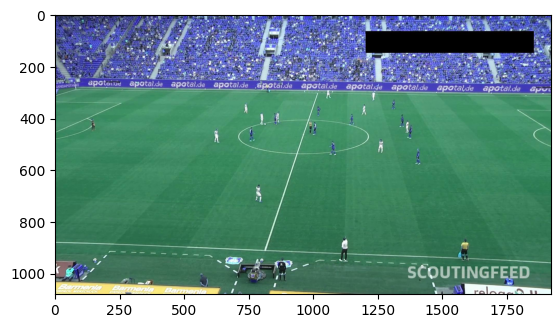

In [104]:
# Getting the image 
im = cv2.imread(str(datasetLoc/'img')+'/'+str(random_pick)+'.jpg')
imshow(im)

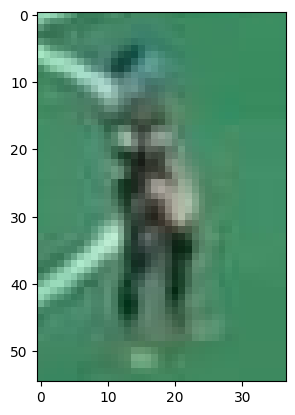

In [105]:
# Showing a single sample 
x = df_random_pick.iloc[0]['x']
y = df_random_pick.iloc[0]['y']
h = df_random_pick.iloc[0]['h']
w = df_random_pick.iloc[0]['w']

single_sample = im[y:y+h,x:x+w]

imshow(single_sample)

In [106]:
# Getting an array for all samples 
CUTOUTS = []

for index in range(len(df_random_pick)):
    x = df_random_pick.iloc[index]['x']
    y = df_random_pick.iloc[index]['y']
    h = df_random_pick.iloc[index]['h']
    w = df_random_pick.iloc[index]['w']

    CUTOUTS.append(im[y:y+h,x:x+w]) 
    

## Hitogram Comparision  using HISTCMP

In [107]:
def compare_hist(img1,img2):
    # Compares Histograms for 2 images 
    # Requires 2 opencv read images 
    img1_hsv = cv2.cvtColor(img1, cv2.COLOR_BGR2HSV)
    img2_hsv = cv2.cvtColor(img2, cv2.COLOR_BGR2HSV)
    
    hist_img1 = cv2.calcHist([img1_hsv], [0,1], None, [180,256], [0,180,0,256])
    cv2.normalize(hist_img1, hist_img1, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX);
    hist_img2 = cv2.calcHist([img2_hsv], [0,1], None, [180,256], [0,180,0,256])
    cv2.normalize(hist_img2, hist_img2, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX);

    return cv2.compareHist(hist_img1, hist_img2, cv2.HISTCMP_BHATTACHARYYA)


0.8372184380109097


<Figure size 640x480 with 0 Axes>

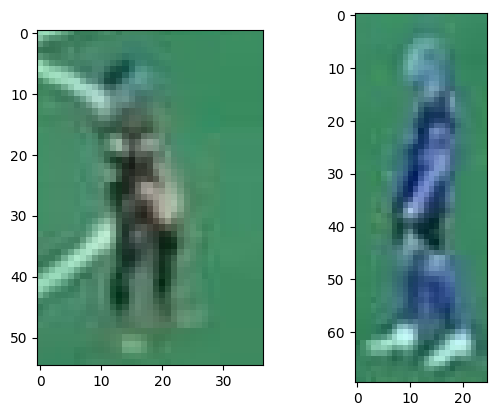

In [108]:
plt.figure()

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(1,2) 

# use the created array to output your multiple images. In this case I have stacked 4 images vertically
axarr[0].imshow(CUTOUTS[0])
axarr[1].imshow(CUTOUTS[1])
print(compare_hist(CUTOUTS[0],CUTOUTS[1]))

0.8293110152849325


<Figure size 640x480 with 0 Axes>

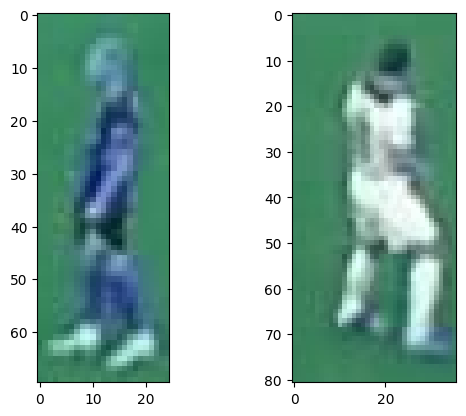

In [109]:
plt.figure()

#subplot(r,c) provide the no. of rows and columns
f, axarr = plt.subplots(1,2) 

# use the created array to output your multiple images. In this case I have stacked 4 images vertically
axarr[0].imshow(CUTOUTS[1])
axarr[1].imshow(CUTOUTS[4])

print(compare_hist(CUTOUTS[1],CUTOUTS[4]))

## Color Based Comparision  using K-Means

In [110]:
import cv2, numpy as np
from sklearn.cluster import KMeans

def visualize_colors(cluster, centroids):
    # Get the number of different clusters, create histogram, and normalize
    labels = np.arange(0, len(np.unique(cluster.labels_)) + 1)
    (hist, _) = np.histogram(cluster.labels_, bins = labels)
    hist = hist.astype("float")
    hist /= hist.sum()

    # Create frequency rect and iterate through each cluster's color and percentage
    rect = np.zeros((50, 300, 3), dtype=np.uint8)
    colors = sorted([(percent, color) for (percent, color) in zip(hist, centroids)])
    start = 0
    for (percent, color) in colors:
#         print(color, "{:0.2f}%".format(percent * 100))
        end = start + (percent * 300)
        cv2.rectangle(rect, (int(start), 0), (int(end), 50), \
                      color.astype("uint8").tolist(), -1)
        start = end
    return rect



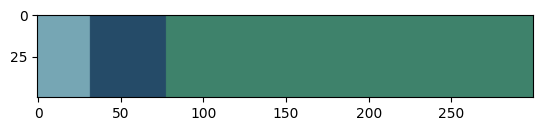

In [111]:
# Load image and convert to a list of pixels

image = cv2.cvtColor(CUTOUTS[1], cv2.COLOR_BGR2RGB)
reshape = image.reshape((image.shape[0] * image.shape[1], 3))

# Find and display most dominant colors
cluster = KMeans(n_clusters=3).fit(reshape)
visualize = visualize_colors(cluster, cluster.cluster_centers_)
visualize = cv2.cvtColor(visualize, cv2.COLOR_RGB2BGR)
imshow(visualize)

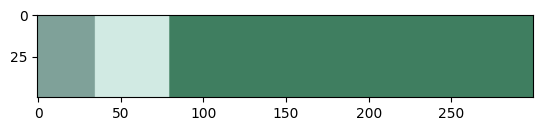

In [112]:
# Load image and convert to a list of pixels

image = cv2.cvtColor(CUTOUTS[4], cv2.COLOR_BGR2RGB)
reshape = image.reshape((image.shape[0] * image.shape[1], 3))

# Find and display most dominant colors
cluster = KMeans(n_clusters=3).fit(reshape)
visualize = visualize_colors(cluster, cluster.cluster_centers_)
visualize = cv2.cvtColor(visualize, cv2.COLOR_RGB2BGR)
imshow(visualize)

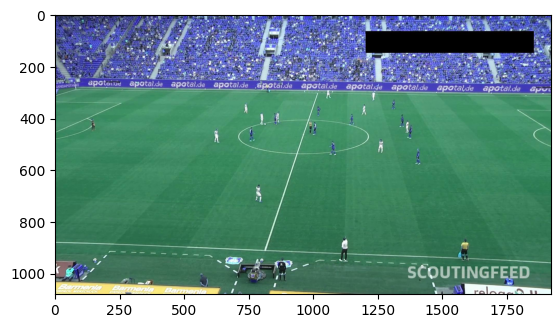

In [113]:
imshow(im)

### Creating a visualization

In [114]:
im_vis = im.copy()

In [115]:
index = 0

for index in range(len(df_random_pick)):
    current = df_random_pick.iloc[index]

    x = current['x']
    y = current['y']
    w = current['w']
    h = current['h']

    im_vis = cv2.rectangle(im_vis, (x, y), (x+w, y+h), (0,0,255), 1)

    # Load image and convert to a list of pixels
    image = cv2.cvtColor(CUTOUTS[index], cv2.COLOR_BGR2RGB)
    reshape = image.reshape((image.shape[0] * image.shape[1], 3))
    # Find and display most dominant colors
    cluster = KMeans(n_clusters=3).fit(reshape)
    visualize = visualize_colors(cluster, cluster.cluster_centers_)
    visualize = cv2.cvtColor(visualize, cv2.COLOR_RGB2BGR)

    scale_percent = 20 # percent of original size
    width = int(visualize.shape[1] * scale_percent / 100)
    height = int(visualize.shape[0] * scale_percent / 100)
    dim = (width, height)
    resized_vis = cv2.resize(visualize, dim, interpolation = cv2.INTER_AREA)

    im_vis[y+h:(y+h+resized_vis.shape[0]),x+w:x+w+resized_vis.shape[1],:] = resized_vis




In [116]:
cv2.imwrite('../outputs/color_team_id.png',im_vis)

True